In [1]:
from collections import defaultdict
import operator
import os
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pecanpy as pp
import scipy
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import auc, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_geometric.nn as gnn
from umap import UMAP

In [2]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [3]:
# Data params
directed = True
disease_type = 'AD'  # Either 'disease' or 'graph-labels' e.g. 'AD', 'AD-SCZ'
def create_dirs(dirs):
    for d in dirs:
        if not os.path.exists(d):
            os.mkdir(d)
def get_dirs(disease_type):
    model_dir = f'./models/{disease_type}'
    results_dir = f'./results/{disease_type}'
    output = (model_dir, results_dir)
    create_dirs(output)
    return output
model_dir, results_dir = get_dirs(disease_type)

# Run params
runs = 20  # Number of runs
folds = 5  # Folds per run
run, fold = 0, 0  # Current stat
percentile = 80  # Data filtering
# RW params
param_grid = {
    'dim': [16, 32, 64, 128, 248, 512],
    'num_walks': [20, 40, 60, 80, 100],
    'walk_length': [10],
    'dropout': [0, .4, .6, .8],
    'gamma': [.96, .99, .995],
    'lr': [1e-1, 1e-2, 1e-3, 1e-4],
}
np.random.seed(42)
dim_list = np.random.choice(param_grid['dim'], runs)
num_walks_list = np.random.choice(param_grid['num_walks'], runs)
walk_length_list = np.random.choice(param_grid['walk_length'], runs)
dropout_list = np.random.choice(param_grid['dropout'], runs)
gamma_list = np.random.choice(param_grid['gamma'], runs)
lr_list = np.random.choice(param_grid['lr'], runs)

# Dataset

In [4]:
def get_cells(disease_type, directed=False):
    cell_fnames = np.array([s for s in os.listdir(f'./data/psychAD_merged_GRN_0.2_0.2/{disease_type.split("-")[0]}') if s[0] != '_'])
    cell_types = [ct.split('.')[0] for ct in cell_fnames]
    cell_fname = cell_fnames[0]
    cell_type = cell_fname.split('.')[0]
    
    return (cell_fnames, cell_types), (cell_fname, cell_type)

(cell_fnames, cell_types), (cell_fname, cell_type) = get_cells(disease_type, directed=directed)
for ct in cell_types:
    print(ct) if ct != cell_type else print(f'--{ct}')

--Astrocyte
Endothelial
GABAergic neuron
GABAergic PVALB interneuron
GABAergic SST interneuron
GABAergic VIP interneuron
Glutamatergic neuron
Microglia
Mural
Oligodendrocyte
OPC


Generating Astrocyte graph...
Filtering data...


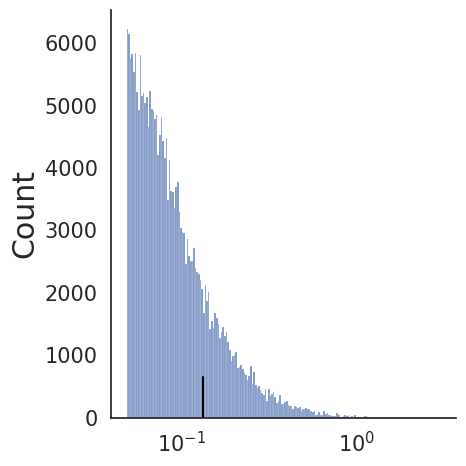

In [5]:
def get_data(cell_fname, method='scGRNom', directed=True, output='_elist.edg'):  # 'scGRNom', 'SCENIC'
    # Read data
    tftg = pd.read_csv(f'./data/psychAD_merged_GRN_0.2_0.2/{disease_type.split("-")[0]}/{cell_fname}', sep='\t', low_memory=False)  # low_memory avoids loading warning
    # Control data
    is_pec2 = (cell_fname.split('.')[1] == 'PEC2')
    coef_col = 'edgeWeight' if not is_pec2 else 'coef'
    # Filter to one method (SCENIC, scGRNom)
    if method is not None and not is_pec2:
        tftg = tftg.iloc[np.argwhere((tftg['method']==method).to_numpy()).flatten(), :]
    # Remove all zero weights
    tftg = tftg.iloc[np.argwhere(tftg[coef_col].to_numpy() != 0).flatten(), :]
    # Remove negatives
    tftg = tftg.iloc[np.argwhere(tftg[coef_col].to_numpy() > 0).flatten(), :]
    # Set all nonzero weights to one
    if method is None and not is_pec2:
        tftg[[coef_col]] = 1.
    # Filter to targets
    tftg = tftg[['TF', 'TG', coef_col]]
    # Make undirected
    tg_genes = np.unique(tftg['TG'])
    if not directed:
        tftg = pd.DataFrame(
            np.concatenate([tftg[['TF', 'TG', coef_col]].to_numpy(), tftg[['TG', 'TF', coef_col]].to_numpy()]))
    # Save file
    tftg.to_csv(output, sep='\t', header=None, index=None)
    
    return tg_genes

def get_labels(genes, disease_type, gene_filter=[]):
    # # DisGeNet
    # disDict = {'AD': 'Alzheimer', 'SCZ': 'Schizophrenia', 'PK': 'Parkinson', 'BD': 'Bipolar Disorder'}
    # meta = pd.read_csv(f'./data/training_labels_disgenet_raw/all_gene_disease_associations.tsv', index_col=None, sep='\t')
    # dis_strs = [s for s in np.unique(meta['diseaseName']) if f'{disDict[disease_type.split("-")[-1]].lower()}' in s.lower() and f'Non-{disDict[disease_type.split("-")[-1]]}'.lower() not in s.lower()]
    # filtered_meta = meta.iloc[[np.array([ds==s for ds in dis_strs]).any() for s in meta['diseaseName']]]
    # filtered_meta = filtered_meta.sort_values('score', ascending=False)
    # filtered_meta = filtered_meta.iloc[:int(.1 * filtered_meta.shape[0])]  # TODO, more fine-tuning
    # positive_genes = np.array(filtered_meta['geneSymbol'])
    
    # Assoc
    positive_genes = pd.read_csv(f'./data/new_labels/{disease_type.split("-")[-1]}.txt', index_col=None, header=None).to_numpy().flatten()
    
    # Get labels
    labels = np.array([('pos' if (g in positive_genes) else 'neg') if (g in gene_filter) else 'unk' for g in genes])  # TODO, better method than unknown being neg
    return labels

def filter_elist(percentile):
    elist = pd.read_csv('_elist.edg', sep='\t', header=None)

    # Eliminate low-value data
    reg_threshold = np.percentile(elist.iloc[:, 2].to_numpy().flatten(), percentile)
    elist = elist.iloc[np.argwhere((elist.iloc[:, 2] >= reg_threshold).to_numpy()).flatten(), :]
    elist.to_csv('_elist.edg', sep='\t', header=None, index=None)
    
    return reg_threshold

print(f'Generating {cell_type} graph...')
# Load data
tg_genes = get_data(cell_fname, directed=directed)

# Plot approximate distribution
elist = pd.read_csv('_elist.edg', sep='\t', header=None)
sns.displot(elist.iloc[:, 2].to_numpy().flatten(), log_scale=True)

# Eliminate low-value data
print(f'Filtering data...')
reg_threshold = filter_elist(percentile)
plt.axvline(reg_threshold, ymax=.1, color='black');

# Pipeline

## Node2Vec+

In [6]:
def get_embeddings_from_elist(model_dir, cell_type, tg_genes, dim, num_walks, walk_length, percentile, run, verbose=False, return_g=False):
    if verbose:
        print('Reading graph...')
    # Load as precomp
    g = pp.pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=False, random_state=42+run)
    g.read_edg('_elist.edg', weighted=True, directed=directed)
    # g.preprocess_transition_probs()

    fname = f'{model_dir}/embeddings-{cell_type}-{run}.npy'
    if os.path.exists(fname):
        if verbose:
            print('Loading embeddings...')
        # Load embeddings
        emb_pp = np.load(fname)
    else:
        if verbose:
            print('Generating embeddings...')
        # Generate embeddings
        emb_pp = g.embed(dim=dim, num_walks=num_walks, walk_length=walk_length)
        np.save(fname, emb_pp)
        hparams = np.array([
            ['percentile', 'dim', 'num_walks', 'walk_length'],
            [percentile, dim, num_walks, walk_length],
        ])
        np.savetxt(fname[:-4]+'.txt', hparams, fmt=' '.join(hparams.shape[1]*['%s']))

    # Chart connected subgraph
    # surviving_nodes = [np.argwhere(genes==gn).flatten()[0] for gn in g.nodes]
    genes = np.array(g.nodes)
    labels = get_labels(genes, disease_type, gene_filter=tg_genes)
    
    output = (genes, labels, emb_pp)
    if return_g:
        return output, g
    return output

dim, num_walks, walk_length = dim_list[run], num_walks_list[run], walk_length_list[run]
genes, labels, emb_pp = get_embeddings_from_elist(model_dir, cell_type, tg_genes, dim, num_walks, walk_length, percentile, run, verbose=True)

Reading graph...
Loading embeddings...


In [7]:
# Additional Graph Information
_, g = get_embeddings_from_elist(model_dir, cell_type, tg_genes, dim, num_walks, walk_length, percentile, run, verbose=False, return_g=True)
walks = g.simulate_walks(num_walks, walk_length)
walk_lengths = np.array([len(walk) for walk in walks])
walk_length_counts = {u: c for u, c in zip(*np.unique(walk_lengths, return_counts=True))}
print(f'Max: {walk_lengths.max()}\nMean: {walk_lengths.mean():.2f}\nMedian: {np.median(walk_lengths):.1f}\n{walk_length_counts}')

Max: 4
Mean: 1.15
Median: 1.0
{1: 188200, 2: 32384, 3: 701, 4: 15}


## Dataset

In [8]:
def generate_dataset(genes, labels, emb_pp, fold, folds, run):
    # Load dataset
    elist = np.loadtxt('_elist.edg', dtype=str)
    gene_to_index = {g: i for g, i in zip(genes, range(len(genes)))}
    edge_index = np.array([[gene_to_index[f] for f in e[:2]] for e in elist]).T
    edge_weight = np.array([float(e[2]) for e in elist])

    # Add embeddings and labels
    x = emb_pp
    y = np.array([{'pos': 1, 'neg': 0, 'unk': 2}[l] for l in labels])

    # Split data
    np.random.seed(42 + run)
    unk_idx = np.argwhere(y==2).flatten()
    unk_mask = np.zeros(x.shape[0], dtype=bool)
    unk_mask[unk_idx] = True
    groups = np.random.choice(folds, x.shape[0])
    train_idx = np.argwhere(groups!=fold).flatten()
    train_idx = np.array(list(set(train_idx) - set(unk_idx)))
    train_mask = np.zeros(x.shape[0], dtype=bool)
    train_mask[train_idx] = True
    val_idx = np.array(list(set(list(range(x.shape[0]))) - set(train_idx)))
    val_idx = np.array(list(set(val_idx) - set(unk_idx)))
    val_mask = np.zeros(x.shape[0], dtype=bool)
    val_mask[val_idx] = True

    # Create dataset
    dataset = tg.data.Data(
        x=torch.tensor(x).float(),
        edge_index=torch.tensor(edge_index, dtype=int),
        edge_weight=torch.tensor(edge_weight).float(),
        y=torch.tensor(y, dtype=int),
        train_mask=torch.tensor(train_mask),
        val_mask=torch.tensor(val_mask),
        unk_mask=torch.tensor(unk_mask))
    assert dataset.is_directed() == directed

    return dataset

dataset = generate_dataset(genes, labels, emb_pp, fold, folds, run)
dataset

Data(x=[2213, 128], edge_index=[2, 48336], y=[2213], edge_weight=[48336], train_mask=[2213], val_mask=[2213], unk_mask=[2213])

## Model Types

In [9]:
# class GCN(torch.nn.Module):
#     def __init__(self, input_size, **kwargs):
#         super().__init__()
#         self.encode = gnn.Sequential('x, edge_index, edge_weight', [
#             (nn.Linear(input_size, 2*input_size), 'x -> x'),
#             # (gnn.GCNConv(32, 64), 'x, edge_index, edge_weight -> x'),
#             # (nn.LeakyReLU(), 'x -> x'),
#             (gnn.GCNConv(2*input_size, input_size), 'x, edge_index, edge_weight -> x'),
#             (nn.LeakyReLU(), 'x -> x'),
#             (gnn.GCNConv(input_size, int(input_size/2)), 'x, edge_index, edge_weight -> x'),
#             (nn.LeakyReLU(), 'x -> x'),
#         ])
#         self.decode = gnn.Sequential('x, edge_index, edge_weight', [
#             (nn.Linear(int(input_size/2), 2), 'x -> x'),
#             # (gnn.GCNConv(16, 2), 'x, edge_index, edge_weight -> x'),
#             (nn.LogSoftmax(dim=-1), 'x -> x'),
#         ])

#     def forward(self, data):
#         x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
#         return self.decode(self.encode(x, edge_index, edge_weight), edge_index, edge_weight)

# model_str = 'gcn'
# model_class = GCN

class MLP(torch.nn.Module):
    def __init__(self, input_size, dropout=.6, **kwargs):
        super().__init__()
        self.encode = nn.Sequential(
            # nn.Dropout(dropout),
            
            nn.Linear(input_size, 2*input_size),
            nn.Dropout(dropout),
            nn.BatchNorm1d(2*input_size),
            nn.LeakyReLU(),
            
            nn.Linear(2*input_size, input_size),
            nn.Dropout(dropout),
            nn.BatchNorm1d(input_size),
            nn.LeakyReLU(),
            
            nn.Linear(input_size, int(input_size/2)),
            nn.Dropout(dropout),
            nn.BatchNorm1d(int(input_size/2)),
            nn.LeakyReLU(),
        )
        self.decode = nn.Sequential(
            nn.Linear(int(input_size/2), 2),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        return self.decode(self.encode(x))
    
model_str = 'mlp'
model_class = MLP

## Training

In [10]:
def generate_model(model_class, dataset, model_dir, model_str, cell_type, dim, num_walks, walk_length, dropout, lr, gamma, percentile, fold, folds, run, verbose=False, return_epoch=False):
    torch.manual_seed(42 + run*folds + fold)
    np.random.seed(42 + run*folds + fold)

    # Train model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_class(dataset.x.shape[1], dropout=dropout).to(device)
    data = dataset.to(device)
    # Optim with lr decay
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

    fname = f'{model_dir}/{model_str}-{cell_type}-{run}-{fold}_{folds}.h5'
    hp_fname = f'{model_dir}/{model_str}-{cell_type}-{run}.txt'
    model.train()
    if os.path.exists(fname):
        epoch = 0
        model.load_state_dict(torch.load(fname))
    else:
        max_lapses = 100; min_improvement = 1e-2  # 500, 50
        min_loss = np.inf; lapses = 0
        for epoch in range(10_001):
            # Step
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Use validation loss
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
            use_loss = val_loss
            
            # CLI
            if use_loss < min_loss - min_improvement:
                min_loss = use_loss.detach()
                lapses = 0
            else:
                lapses += 1
            if lapses >= max_lapses:
                if verbose:
                    print(f'Epoch {epoch}\nTrain Loss: {float(loss.detach()):.4f}\nValid Loss: {float(val_loss.detach()):.4f}')
                break
            if epoch % 100 == 0:
                # val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
                if verbose:
                    print(f'Epoch {epoch}\nTrain Loss: {float(loss.detach()):.4f}\nValid Loss: {float(val_loss.detach()):.4f}')
        torch.save(model.state_dict(), fname)
        hparams = np.array([
            ['percentile', 'dim', 'num_walks', 'walk_length', 'dropout', 'lr', 'gamma'],
            [percentile, dim, num_walks, walk_length, dropout, lr, gamma],
        ])
        np.savetxt(hp_fname, hparams, fmt=' '.join(hparams.shape[1]*['%s']))
    model.eval()
    
    if return_epoch:
        return model, epoch
    return model


dropout, lr, gamma = dropout_list[run], lr_list[run], gamma_list[run]
model = generate_model(model_class, dataset, model_dir, model_str, cell_type, dim, num_walks, walk_length, dropout, lr, gamma, percentile, fold, folds, run, verbose=True)

In [11]:
def evaluate_predictions(model, dataset, labels):
    pred_raw = model(dataset).detach()
    pred = pred_raw.argmax(dim=1)
    threshold = pred_raw[dataset.train_mask, 1].flatten().quantile(1 - (sum(labels=='pos') / (sum(labels=='pos') + sum(labels=='neg'))))
    logits = pred_raw[:, 1][dataset.val_mask]
    trans = {'pos': 1, 'neg': 0, 'unk': 2}
    trans_inv = {v: k for k, v in trans.items()}
    true = torch.Tensor([trans[l] for l in labels[dataset.val_mask]]).long()

    # AUROC
    fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
    auroc = auc(fpr, tpr)

    return auroc, pred_raw

auroc, pred_raw = evaluate_predictions(model, dataset, labels)
print(f'AUROC:\t{auroc:.4f}')

AUROC:	0.5414


### Advanced Evaluation

In [12]:
# pred_raw = model(dataset.to(device)).detach()
# pred = pred_raw.argmax(dim=1)
# threshold = pred_raw[data.train_mask, 1].flatten().quantile(1 - (sum(labels=='pos') / (sum(labels=='pos') + sum(labels=='neg'))))

# print('Evaluating performance...')
# print('Train')
# ## Train
# # Perform prediction
# logits = pred_raw[:, 1][data.train_mask]
# trans = {'pos': 1, 'neg': 0, 'unk': 2}
# trans_inv = {v: k for k, v in trans.items()}
# true = torch.Tensor([trans[l] for l in labels[dataset.train_mask]]).long()

# # Get confusion
# conf = confusion_matrix(true, 1*(logits > threshold))
# # conf = confusion_matrix(true, pred)
# print('T\P\t' + '\t'.join([trans_inv[i] for i in range(len(trans_inv)-1)]))
# for i, row in enumerate(conf):
#     print(trans_inv[i] + '\t' + '\t'.join([str(e) for e in row]))

# # Other statistics
# fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
# print(f'AUROC:\t{auc(fpr, tpr):.4f}')
# prec, rec, thresholds = precision_recall_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
# print(f'AUPRC:\t{auc(rec, prec):.4f}')
# correct = (pred[data.train_mask] == data.y[dataset.train_mask]).sum()
# acc = int(correct) / int(dataset.train_mask.sum())
# print(f'Accuracy: {acc:.4f}')
# print()

# print('Eval')
# ## Eval
# # Perform prediction
# logits = pred_raw[:, 1][data.val_mask]
# trans = {'pos': 1, 'neg': 0, 'unk': 2}
# trans_inv = {v: k for k, v in trans.items()}
# true = torch.Tensor([trans[l] for l in labels[dataset.val_mask]]).long()

# # Get confusion
# conf = confusion_matrix(true, 1*(logits > threshold))
# # conf = confusion_matrix(true, pred)
# print('T\P\t' + '\t'.join([trans_inv[i] for i in range(len(trans_inv))]))
# for i, row in enumerate(conf):
#     print(trans_inv[i] + '\t' + '\t'.join([str(e) for e in row]))

# # Other statistics
# fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
# print(f'AUROC:\t{auc(fpr, tpr):.4f}')
# prec, rec, thresholds = precision_recall_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
# print(f'AUPRC:\t{auc(rec, prec):.4f}')
# correct = (pred[dataset.val_mask] == dataset.y[dataset.val_mask]).sum()
# acc = int(correct) / int(dataset.val_mask.sum())
# print(f'Accuracy: {acc:.4f}')
# print()

## Folds

In [ ]:
auroc_list = []
ad_dict = defaultdict(lambda: np.zeros(3))
for cell_fname in cell_fnames:
    cell_type = cell_fname.split('.')[0]
    print(f'---------{cell_type}')

    auroc_list.append([])
    for run in range(runs):
        print(f'------Run {run+1}')
        
        auroc_list[-1].append([])
        for fold in range(folds):
            print(f'---Fold {fold+1}', end='\t')
            
            ### Generate graph
            tg_genes = get_data(cell_fname, directed=directed)
            reg_threshold = filter_elist(percentile)

            ### Read graph
            dim, num_walks, walk_length = dim_list[run], num_walks_list[run], walk_length_list[run]
            dropout, lr, gamma = dropout_list[run], lr_list[run], gamma_list[run]
            genes, labels, emb_pp = get_embeddings_from_elist(model_dir, cell_type, tg_genes, dim, num_walks, walk_length, percentile, run)
                                        
            ### Make dataset
            dataset = generate_dataset(genes, labels, emb_pp, fold, folds, run)

            ### Train model
            model, end_epoch = generate_model(model_class, dataset, model_dir, model_str, cell_type, dim, num_walks, walk_length, dropout, lr, gamma, percentile, fold, folds, run, return_epoch=True)
            
            ### Perform predictions
            auroc, pred_raw = evaluate_predictions(model, dataset, labels)
            auroc_list[-1][-1].append(auroc)
            # for i, g in enumerate(genes):
            #     if (dataset.unk_mask[i] or dataset.val_mask[i]) and auroc > .5:
            #         ad_dict[g] += np.array([auroc**2 * np.exp(float(pred_raw[i, 1])), auroc**2, 1])
            
            ### CLI
            print(f'AUROC:\t{auroc:.4f}', end='\t')
            print(f'Epochs:\t{end_epoch}')

---------Astrocyte
------Run 1
---Fold 1	AUROC:	0.5414	Epochs:	0
---Fold 2	AUROC:	0.4432	Epochs:	0
---Fold 3	AUROC:	0.6545	Epochs:	0
---Fold 4	AUROC:	0.3664	Epochs:	0
---Fold 5	AUROC:	0.5503	Epochs:	0
------Run 2
---Fold 1	AUROC:	0.6806	Epochs:	0
---Fold 2	AUROC:	0.5968	Epochs:	0
---Fold 3	AUROC:	0.4296	Epochs:	0
---Fold 4	AUROC:	0.4495	Epochs:	0
---Fold 5	AUROC:	0.4912	Epochs:	0
------Run 3
---Fold 1	AUROC:	0.5597	Epochs:	0
---Fold 2	AUROC:	0.4616	Epochs:	0
---Fold 3	AUROC:	0.5245	Epochs:	0
---Fold 4	AUROC:	0.4515	Epochs:	0
---Fold 5	AUROC:	0.7225	Epochs:	0
------Run 4
---Fold 1	AUROC:	0.4510	Epochs:	0
---Fold 2	AUROC:	0.3838	Epochs:	0
---Fold 3	AUROC:	0.6785	Epochs:	0
---Fold 4	AUROC:	0.4722	Epochs:	0
---Fold 5	AUROC:	0.5814	Epochs:	0
------Run 5
---Fold 1	AUROC:	0.5058	Epochs:	0
---Fold 2	AUROC:	0.5677	Epochs:	0
---Fold 3	AUROC:	0.5279	Epochs:	0
---Fold 4	AUROC:	0.4751	Epochs:	0
---Fold 5	AUROC:	0.4699	Epochs:	0
------Run 6
---Fold 1	AUROC:	0.6530	Epochs:	0
---Fold 2	AUROC:	0.3765	E

In [ ]:
# Save performance
np.save(f'{results_dir}/auroc-{runs}-{folds}.npy', auroc_list)

# Results

In [ ]:
# Load performances
diseases = [
    d for d in np.intersect1d(os.listdir(get_dirs('')[0]), os.listdir(get_dirs('')[1]))
    if np.array([bad_text not in d for bad_text in ('old', 'enrichment', 'ipynb')]).all()]
# diseases.sort(key=lambda d: ('-' in d))
auroc_lists = [np.load(f'{get_dirs(d)[1]}/auroc-{runs}-{folds}.npy') for d in diseases]

# Convert to pandas df
df = pd.DataFrame(data={
    'disease': np.concatenate([
        folds*[d]
        for d in diseases
        for cts in [[s.split('.')[0] for s in os.listdir(f'./data/psychAD_merged_GRN_0.2_0.2/{d.split("-")[0]}') if s[0] != '_']]
        for ct in cts
    ]),
    'cell_type': np.concatenate([
        folds*[ct]
        for d in diseases
        for cts in [[s.split('.')[0] for s in os.listdir(f'./data/psychAD_merged_GRN_0.2_0.2/{d.split("-")[0]}') if s[0] != '_']]
        for ct in cts
    ]),
    'fold': np.concatenate([
        list(range(folds))
        for d in diseases
        for cts in [[s.split('.')[0] for s in os.listdir(f'./data/psychAD_merged_GRN_0.2_0.2/{d.split("-")[0]}') if s[0] != '_']]
        for ct in cts
    ]),
    'auroc': np.concatenate([np.concatenate(al[list(range(al.shape[0])), np.array(al).mean(axis=-1).argmax(axis=-1), :]) for al in auroc_lists]),
}).sort_values(['cell_type', 'disease', 'fold'])  # Sorting required for patches with missing runs
# Cherry-pick
# df = df.iloc[[e not in np.array(cell_types)[[4, 7, 9, 10]] for e in df['cell_type']]]  # Remove cell types

In [ ]:
# Style
sns.set_palette('husl', len(diseases))
style = {
    'boxprops': {'edgecolor': None},
    'medianprops': {'color': 'red', 'linewidth': 1},
    'whiskerprops': {'color': 'black', 'linewidth': 1},
    # 'capprops': {'alpha': 0},
}

# Create Figure
fig, axs = plt.subplots(1, 1, figsize=(8, 4+2*len(diseases)), sharey=True)
axs = [axs]

# Barplot
sns.boxplot(ax=axs[0], data=df, x='auroc', y='cell_type', hue='disease', **style)
sns.move_legend(axs[0], 'upper right')
sns.despine(ax=axs[0], left=True, bottom=True)

# Labels
axs[0].set_xlabel('AUROC')
axs[0].set_ylabel('Cell Type')

# Markers
axs[0].axvline(x=.5, color='black', linestyle='--', linewidth=.5)
axs[0].set_xlim([.4, 1. if np.max(df['auroc']) > .8 else .8])

# Fade out alt runs
box_patches = [patch for patch in axs[0].patches if type(patch) == mpl.patches.PathPatch]
lines_per_boxplot = len(axs[0].lines) // len(box_patches)
for i, patch in enumerate(box_patches):
    # disease = diseases[i % len(diseases)]
    disease = df.sort_values(['cell_type', 'disease']).iloc[::folds].iloc[i]['disease']
    if '-' in disease:
        # Change patch
        patch.set_alpha(.2)
        
        # Change lines
        for line in axs[0].lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_alpha(.2)
            
# Save figure
plt.tight_layout()
plt.savefig(f'{get_dirs("")[1][:-1]}/fig_performance_box-{runs}-{folds}.png', dpi=300, bbox_inches='tight')

In [ ]:
# Create Figure
fig, axs = plt.subplots(1, 1, figsize=(2*len(diseases), len(np.unique(df['cell_type']))))
axs = [axs]

# Plot
df_averages = (
    df
    .groupby(['cell_type', 'disease'])
    .mean()
    .drop(columns='fold')
    .reset_index()
    .pivot(index='cell_type', columns='disease', values='auroc')
)
ax = sns.heatmap(df_averages, vmin=.4, cmap='mako')

# Highlight max per row (https://stackoverflow.com/questions/62696868/highlighting-maximum-value-in-a-column-on-a-seaborn-heatmap)
from matplotlib.patches import Circle, Rectangle
row_max = df_averages.idxmax(axis=1)

for row, index in enumerate(df_averages.index):
    positions = np.argsort(np.nan_to_num(np.array(df_averages.iloc[row])))[::-1][:2]
    # position = df_averages.columns.get_loc(row_max[index])
    for position in positions:
        # ax.add_patch(Rectangle((position, row), 1, 1, fill=False, edgecolor='#FF0000', lw=2))
        ax.add_patch(Circle((position+.5, row+.5), radius=1/32, color='#FF0000', lw=2))

# Save figure
plt.tight_layout()
plt.savefig(f'{get_dirs("")[1][:-1]}/fig_performance_heat-{runs}-{folds}.png', dpi=300, bbox_inches='tight')

In [ ]:
# Load data
auroc_list = np.load(f'{results_dir}/auroc-{runs}-{folds}.npy')

# Predict per cell type
predictions = []
for i, (cell_type, cell_fname) in enumerate(zip(cell_types, cell_fnames)):
    print(f'Running {cell_type} predictions', end='\t')
    # Get best avg auroc for cell type
    run = np.nanmean(auroc_list[i], axis=-1).argmax()
    # Print hparams
    print('(', end='')
    for j, (hp_name, hp_val) in enumerate(zip(*np.loadtxt(f'{model_dir}/{model_str}-{cell_type}-{run}.txt', dtype=str))):
        if j == 0:
            print(f'{hp_name}: {hp_val}', end='')
        else:
            print(f', {hp_name}: {hp_val}', end='')
    print(')')
    
    # Get validation predictions from each fold (TODO: Train on all data, one prediction)
    for fold in range(folds):
        # Predict
        tg_genes = get_data(cell_fname, directed=directed)
        reg_threshold = filter_elist(percentile)
        dim, num_walks, walk_length = dim_list[run], num_walks_list[run], walk_length_list[run]
        dropout, lr, gamma = dropout_list[run], lr_list[run], gamma_list[run]
        genes, labels, emb_pp = get_embeddings_from_elist(model_dir, cell_type, tg_genes, dim, num_walks, walk_length, percentile, run)
        dataset = generate_dataset(genes, labels, emb_pp, fold, folds, run)
        model = generate_model(model_class, dataset, model_dir, model_str, cell_type, dim, num_walks, walk_length, dropout, lr, gamma, percentile, fold, folds, run)
        auroc, pred_raw = evaluate_predictions(model, dataset, labels)
        
        # Record predictions
        if fold == 0:
            predictions_cell = np.zeros_like(pred_raw[:, 1])
        assert np.sum(np.abs(predictions_cell[dataset.val_mask])) == 0
        predictions_cell[dataset.val_mask] += pred_raw[dataset.val_mask][:, 1].numpy()
        
    # Format predictions
    predictions_cell = np.array([[g, float(p)] for g, p in zip(genes, pred_raw[:, 1])])
    predictions_cell = predictions_cell[np.argsort(predictions_cell[:, 1].astype(float))[::-1]]
        
    # Save predictions
    fname = f'{results_dir}/{model_str}-{cell_type}-{runs}-{folds}-Predictions.txt'
    np.savetxt(fname, predictions_cell, fmt='%s %s')
        
    predictions.append(predictions_cell)
    
# Concatenate
# np.array(predictions)  # Sometimes ragged

In [ ]:
# Get best cell type
best_cell = (
    np.nanmean(
        auroc_list,
        axis=-1,
    )  # Average fold
    .max(axis=-1)  # Max run
    .argmax()  # Best cell idx
)

print(f'{cell_types[best_cell]} ({np.nanmean(auroc_list[best_cell], axis=-1).max():.3f}):')
for g in predictions[best_cell][:100, 0]:
    print(g)

# Visualization

In [ ]:
# Set colors
sns.set_palette('husl', 3)

# Maps
name_map = {'pos': 'Disease', 'neg': 'Not Disease', 'unk': 'Unknown'}
color_map = {'pos': np.array((1, .2, .2)), 'neg': np.array((.2, .2, 1)), 'unk': np.array((0, 0, 0))}
z_map = {'pos': 2, 'neg': 1, 'unk': 0}
s_map = {'pos': 10., 'neg': 1., 'unk': .5}

# Translation
trans = {'pos': 1, 'neg': 0, 'unk': 2}
trans_inv = {v: k for k, v in trans.items()}

In [ ]:
%%capture
from matplotlib.lines import Line2D

# Legend
legend = [
    Line2D([], [], color=(1, 1, 1, 0), markerfacecolor=color_map[l], marker='o', markersize=10)
    for l in name_map]
legend_names = [name_map[l] for l in name_map]

# Plot legend
fig, ax = plt.subplots()
legend = ax.legend(legend, legend_names, loc='center', frameon=False, ncol=len(legend)//1)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{results_dir}/fig_legend.png', bbox_inches=bbox, dpi=300)

In [ ]:
from IPython.display import display, Image
display( Image(filename=f'{results_dir}/fig_legend.png', width=800) )

In [ ]:
### Get best model
auroc_list = np.load(f'{results_dir}/auroc-{runs}-{folds}.npy')
ct, run, fold = np.unravel_index(np.nanargmax(auroc_list), auroc_list.shape)
cell_type, cell_fname = cell_types[ct], cell_fnames[ct]

### Load best model
tg_genes = get_data(cell_fname, directed=directed)
reg_threshold = filter_elist(percentile)
dim, num_walks, walk_length = dim_list[run], num_walks_list[run], walk_length_list[run]
dropout, lr, gamma = dropout_list[run], lr_list[run], gamma_list[run]
genes, labels, emb_pp = get_embeddings_from_elist(model_dir, cell_type, tg_genes, dim, num_walks, walk_length, percentile, run)
dataset = generate_dataset(genes, labels, emb_pp, fold, folds, run)
model = generate_model(model_class, dataset, model_dir, model_str, cell_type, dim, num_walks, walk_length, dropout, lr, gamma, percentile, fold, folds, run)
auroc, pred_raw = evaluate_predictions(model, dataset, labels)

In [ ]:
np.random.seed(42)
# submask = torch.tensor((np.random.rand(dataset.x.shape[0]) > .7), dtype=bool)
submask = dataset.val_mask
G = tg.utils.to_networkx(dataset.subgraph(np.argwhere(submask).flatten()), node_attrs=['x'], edge_attrs=['edge_weight'], to_undirected=not directed)
edge_color = [(0, 0, 0, .1*G[u][v]['edge_weight'] / float(dataset.subgraph(np.argwhere(submask).flatten()).edge_weight.max())) for u, v in G.edges]
pos = nx.spring_layout(G, weight='edge_weight', k=.5)

# Original Data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
node_color = [color_map[trans_inv[int(v)]] for v in dataset.y[submask]]
nx.draw(
    G,
    node_color=node_color,
    edge_color=edge_color,
    node_size=10,
    pos=pos,
)
plt.title('Gene Coregulation')
plt.savefig(f'{results_dir}/fig_data-{runs}-{folds}.png', dpi=300)

# Computed Data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# pred = model(dataset).detach().argmax(dim=1)
threshold = pred_raw[dataset.train_mask, 1].flatten().quantile(1 - (sum(labels=='pos') / (sum(labels=='pos') + sum(labels=='neg'))))
pred = 1*(model(dataset).detach()[:, 1] > threshold)
# Show known
# node_color = [color_map[trans_inv[int(v)]] if v != 2 else color_map[trans_inv[int(w)]] for v, w in zip(dataset.y[submask], pred[submask])]
# Do not show known
# node_color = [color_map[trans_inv[int(v)]] for v in pred[submask]]
# Show spectrum
strong_range = np.std(pred_raw[submask, 1].exp().numpy())
center = np.percentile(pred_raw[submask, 1].exp().numpy(), 90)
min_range, max_range = center - strong_range, center + strong_range
node_color = [
    np.array(
        (1-((max(min(v[1], max_range), min_range) - min_range)/(2*strong_range)))*color_map['neg']
        + ((max(min(v[1], max_range), min_range) - min_range)/(2*strong_range))*color_map['pos']
    )
        for v in pred_raw[submask].exp().numpy()]
node_color = [[max(min(cv, 1), 0) for cv in c] for c in node_color]
nx.draw(
    G,
    node_color=node_color,
    edge_color=edge_color,
    node_size=10,
    pos=pos,
)
plt.title('Predicted Disease')
plt.savefig(f'{results_dir}/fig_prediction-{runs}-{folds}.png', dpi=300)